In [18]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image #para tratar imagens
import tensorflow_datasets as tfds
import pathlib #para receber o diretorio
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import utils, Model, datasets, models
from tensorflow.keras.layers import Dense, Flatten, Conv2D

In [19]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname = 'flower_photos', untar = True)
data_dir = pathlib.Path(dataset_url)

In [20]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

0


De alguma forma, não está funcionando. Fica pra depois descobrir como importar.

In [21]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [22]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


([], [])

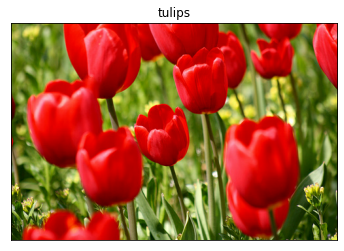

In [23]:
get_label_name = metadata.features['label'].int2str

image,label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))
plt.xticks([])
plt.yticks([])

# Criando um modelo de convulação
O modelo de convulação, também chamado de CNN é mais preciso que o modelo de classificação normal, pois ele leva em consideração a [distância entre cada pixel](https://medium.com/@lucaaslb/deep-learning-vis%C3%A3o-computacional-redes-neurais-convolucionais-c21f19f5ec34)!
    


In [48]:
#modelo para predizer imagens pré tratadas
class cnnModel(Model):
    def __init__(self):
        super(cnnModel, self).__init__()
        self.conv1 = Conv2D(32,3,activation = 'relu')
        self.flatten = Flatten()
        self.d1 = Dense(128,activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

CNNmodel = cnnModel()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = keras.optimizers.Adam()

In [49]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

In [50]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = CNNmodel(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, CNNmodel.trainable_variables)
    optimizer.apply_gradients(zip(gradients,CNNmodel.trainable_variables))

    train_loss(loss)
    train_accuracy(labels,predictions)

In [51]:
@tf.function
def test_step(images, labels):
    predictions = CNNmodel(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [52]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache()

# TREINO é TREINO

In [53]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()
    test_accuracy.reset_states()

    for images,labels in train_ds:
        train_step(images,labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
      )

ValueError: in user code:

    <ipython-input-38-6146a7c9fbd0>:4 train_step  *
        predictions = CNNmodel(images, training=True)
    <ipython-input-24-ecd1b7c90056>:10 call  *
        x = self.conv1(x)
    /mnt/e/Programming/SmartCitiesML/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /mnt/e/Programming/SmartCitiesML/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:230 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (333, 500, 3)
